# Plotting ORACLES flight paths

In [2]:
# import neccesary modules for this module
#-------------------------------------------
import pandas as pd
import numpy as np
import scipy as sio
import scipy.stats as stats
from scipy.interpolate import griddata, interp2d
import glob
import netCDF4 as nc4
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.patches import Polygon
from matplotlib.patches import Polygon
from mpl_toolkits.basemap import Basemap
import shapefile
import os, math, sys
import datetime as dt
import time as tm
import csv
%matplotlib inline

In [3]:
# open and read netcdf file
def read_nc_file( nc_file, varname ):
    f = nc4.Dataset(nc_file)
    data = f.variables[varname]
    #f.close()
    return data;

In [4]:
# convert netcdf var (colname is name we want to save to) 
# doesn't have to be the original column (var) name
# to data frame
# this is just per 1D variable
def nc2df_1( nc_data, colname ):
    df = pd.DataFrame([])
    df=df.append(pd.DataFrame(nc_data[:]))
    # rename column name
    df.rename(columns=lambda x: colname, inplace=True)
    return df;

In [184]:
## this function reads archived netcdf files
## and combines flight paths to one dataset
##
## Michal Segal, 10-23-2017
## data_dir = '..//..//py_data//oracles_NN//'
## subdir is the netcdf locations of flight path data
## er2_subdir is: "ORACLES_2016_ER2_archive"
## p3_subdir is: "ORACLES_2017_P3_archive"
##---------------------------------------------------------------------------
def createORACLESflightPaths(data_dir,er2_subdir,p3_subdir):
    
    # import moduls
    import numpy as np
    import scipy as sio
    from os import listdir
    from os.path import isfile, join
    from os import walk
    import pandas as pd
    import glob
    import matplotlib 
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib.collections import LineCollection
    from matplotlib.patches import Polygon
    from matplotlib.patches import Polygon
    from mpl_toolkits.basemap import Basemap
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import shapefile
    %matplotlib inline
    
    # list all files in ER-2 folder to plot
    expres = data_dir + er2_subdir + '//' + "*.nc"  
    er2_flist = glob.glob(expres)
    print "er2_files to process: "
    print er2_flist
    
    # list all files in P-3 folder to plot
    expres = data_dir + p3_subdir + '//' + "*.nc"  
    p3_flist = glob.glob(expres)
    print "p3_files to process: "
    print p3_flist
    
    ## initialize arrays
    er2_data = pd.DataFrame([])
    p3_data  = pd.DataFrame([])
    data     = pd.DataFrame([])
    
    # read and concatanate files:
    # ER-2
    for f in range(len(er2_flist)):
        print er2_flist[f]
        tmp_lat = read_nc_file( er2_flist[f], "Latitude" )
        tmp_lon = read_nc_file( er2_flist[f], "Longitude" )
        
        er2_lat  = nc2df_1( tmp_lat, "Latitude" )
        er2_lon  = nc2df_1( tmp_lon, "Longitude" )
        #print er2_lat.head()
        #print er2_lon.head()
        
        # extract data date
        file_in__ = er2_flist[f].split('//')
        #print file_in__
        file_in_  = str(file_in__[-1]).split('\\')[-1]
        #print file_in_                                    
        file_in   = str(file_in_).split('_')[2]
        #print file_in
        #er2_date
        # create data frame
        #er2_df_ = pd.DataFrame({'Date': file_in , 'Latitude': er2_lat, "Longitude": er2_lon, "Platform": "ER-2"})
        er2_df_ = pd.concat([er2_lat,er2_lon], axis=1)
        
        #er2_df_[er2_df_["Longitude"]>15] = np.nan
        #er2_df_[(er2_df_['Longitude']>15)] = np.nan
        
        #er2_df_.loc[er2_df_['Longitude'] > 15., 'Longitude'] = np.nan
        er2_df_[er2_df_['Longitude'].apply(lambda x: x > 15.)] = np.nan
        
        print "er2_df_ shape:"
        print er2_df_.shape
        print er2_df_.head()
        
        # add date:
        er2_df_['Date']     = file_in
        # add platform name
        er2_df_['Platform'] = "ER-2"
        
        # concat DF for all dates
        er2_data=er2_data.append(pd.DataFrame(er2_df_))
    
    # re-index according to row numbers
    er2_data.index = range(len(er2_data))
    
    print "er2_data shape:"
    print er2_data.shape
    print "ER-2_data example (1000:1120)"
    print er2_data[1120:1220]
    print "ER-2_data describe"
    print er2_data['Longitude'].describe()
    
    
    # P-3
    for f in range(len(p3_flist)):
        print p3_flist[f]
        tmp_lat = read_nc_file( p3_flist[f], "Latitude" )
        tmp_lon = read_nc_file( p3_flist[f], "Longitude" )
        
        p3_lat  = nc2df_1( tmp_lat, "Latitude" )
        p3_lon  = nc2df_1( tmp_lon, "Longitude" )
        #print p3_lat.head()
        #print p3_lon.head()
        
        # extract data date
        file_in__ = p3_flist[f].split('//')
        #print file_in__
        file_in_  = str(file_in__[-1]).split('\\')[-1]
        #print file_in_                                    
        file_in   = str(file_in_).split('_')[2]
        #print file_in
        
        # create data frame
        
        p3_df_ = pd.concat([p3_lat,p3_lon], axis=1)
        #print "p3_df_ shape:"
        #print p3_df_.shape
        #print p3_df_.head()
        
        # add date:
        p3_df_['Date'] = file_in
        # add platform name:
        p3_df_['Platform'] = "P-3"
        
        # concat DF for all dates
        p3_data=p3_data.append(pd.DataFrame(p3_df_))
    
    # re-index according to row numbers
    p3_data.index = range(len(p3_data))
    print "p3_data shape:"
    print p3_data.shape
    print "P-3_data example (100:120)"
    print p3_data[100:120]
    
    
    # combine both flight paths
    data = er2_data.append(p3_data)
    
    return data
    
    

In [185]:
# test
data_dir = '..//..//py_data//oracles_NN//'
er2_subdir = "ORACLES_2016_ER2_archive"
p3_subdir  = "ORACLES_2017_P3_archive"
flightpath_data = createORACLESflightPaths(data_dir,er2_subdir,p3_subdir)
flightpath_data.shape

er2_files to process: 
['..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160910_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160912_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160914_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160916_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160918_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160920_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160922_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160924_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160925_R1.nc', '..//..//py_data//oracles_NN//ORACLES_2016_ER2_archive\\mrg60_ER2_20160927_R1.nc']
p3_files to process: 
['..//..//py_data//oracles_NN//ORACLES_2017_P3_archive\\mrg1_P3_20170809_R4.nc', '..//..//py_data//oracles_NN//ORACLES_2017_

(405785, 4)

In [196]:
## lat_1 - southern latitude
## lat_2 - northern latitude
## lat_0 - middle latitude
## lon_0 - middle longitude
## llcrnrlon=30.,llcrnrlat=20.,urcrnrlon=-160.,urcrnrlat=63
## m_width - width of draen map in projection units (e.g., 3500000)
## m_height- height of drawn map in projection units
## plot flight paths on map
## this is for ORACLES 2016-17
##-----------------------------

def plotORACLESflightPaths_2subplots(data,lat_1,lat_2,lat_0,lon_0,m_width,m_height):
    
    # import moduls
    import numpy as np
    import scipy as sio
    from os import listdir
    from os.path import isfile, join
    from os import walk
    import pandas as pd
    import glob
    import matplotlib 
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib.collections import LineCollection
    from matplotlib.patches import Polygon
    from matplotlib.patches import Polygon
    from mpl_toolkits.basemap import Basemap
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import shapefile
    %matplotlib inline
    

    
    fig, axes = plt.subplots(1,2)
  
    projection = 'lcc'
    
    resolution = 'i'
    # ORACLES 2016
    #lat_1 = -30.
    #lat_2 = 5.
    #lat_0 = -15.
    #lon_0 = 5.
    m_min = lon_0 + (-20.)
    m_max = lon_0 + 25.

    parallels = np.arange(lat_1, lat_2, 5)
    meridians = np.arange(m_min, m_max, 10)
    
    # the fisrt subplot - ER-2 2016 flight paths
    axes[0].set_title('ER-2 flights 2016')
    m0 = Basemap(width = m_width, height = m_height,
                projection = projection,
                lat_1 = lat_1, lat_2 = lat_2, 
                lat_0 = lat_0, lon_0 = lon_0,
                resolution = resolution,ax=axes[0])
    
    
    #m0 = Basemap(width = m_width, height = m_height,
    #            projection = projection,
    #            llcrnrlon=-20.,llcrnrlat=20.,
    #            urcrnrlon=-30.,urcrnrlat=10.,
    #            resolution = resolution,ax=axes[0])
    
    m0.bluemarble(scale=0.25)
    m0.drawparallels(parallels, labels=[1,0,0,0], fontsize=8, 
       linewidth=1.)
    m0.drawmeridians(meridians, labels=[0,0,0,1], fontsize=8, 
       linewidth=1.)
   

    # the fisrt subplot - P-3 2017 flight paths
    axes[1].set_title('P-3 flights 2017')
    m1 = Basemap(width = m_width, height = m_height,
                projection = projection,
                lat_1 = lat_1, lat_2 = lat_2, 
                lat_0 = lat_0, lon_0 = lon_0,
                resolution = resolution,ax=axes[1])
    m1.bluemarble(scale=0.25)
    m1.drawparallels(parallels, labels=[1,0,0,0], fontsize=8, 
       linewidth=1.)
    m1.drawmeridians(meridians, labels=[0,0,0,1], fontsize=8, 
       linewidth=1.)
   
    
    # set colormap
    colormap = plt.cm.nipy_spectral #plt.cm.gist_ncar #nipy_spectral, Set1,Paired
    # plot ER-2 paths
    subset = data[data['Platform']=="ER-2"]
    u_date = np.unique(subset['Date'])
    print u_date
    
    for i in range(len(u_date)):
        print u_date[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0,label=Jday[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0)
        tmp = subset[subset['Date']==u_date[i]]
        #print tmp.head()
        
        m0.plot(np.asarray(tmp["Longitude"]),np.asarray(tmp["Latitude"]),':',
                latlon=True, linewidth=2.0,label=u_date[i])# works with axes[0].legend
        
       
    colors = [colormap(i) for i in np.linspace(0, 1,len(axes[0].lines))]
    
    for i,j in enumerate(axes[0].lines):
        j.set_color(colors[i])
    #map0 = plt.gca()
    #handles, labels = map0.get_legend_handles_labels()
    #legend = plt.legend(u_date[i])
    #axes[0].legend(loc="lower_center",fontsize=8)
    
    # Shrink current axis's height by 10% on the bottom
    box0 = axes[0].get_position()
    axes[0].set_position([box0.x0, box0.y0 + box0.height * 0.2,
                 box0.width, box0.height * 0.8])

    # Put a legend below current axis
    #axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    axes[0].legend(loc='upper center',bbox_to_anchor = (0.5, -0.1),
          fancybox=True, shadow=False, ncol=2,fontsize = 8)   
    
    # plot P-3 paths
    subset = data[data['Platform']=="P-3"]
    u_date = np.unique(subset['Date'])
    print u_date
    
    for i in range(len(u_date)):
        print u_date[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0,label=Jday[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0)
        tmp = subset[subset['Date']==u_date[i]]
        #print tmp.head()
        
        m1.plot(np.asarray(tmp["Longitude"]),np.asarray(tmp["Latitude"]),'--',
                latlon=True, linewidth=2.0,label=u_date[i])

    
       
    colors = [colormap(i) for i in np.linspace(0, 1,len(axes[1].lines))]
    
    for i,j in enumerate(axes[1].lines):
        j.set_color(colors[i])
    #axes[1].legend(loc="upper_right",fontsize=8)
    
    # Shrink current axis's height by 10% on the bottom
    box1 = axes[1].get_position()
    axes[1].set_position([box1.x0, box1.y0 + box1.height * 0.2,
                 box1.width, box1.height * 0.8])

    # Put a legend below current axis
    #axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    axes[1].legend(loc='upper center',bbox_to_anchor = (0.5, -0.1),
          fancybox=True, shadow=False, ncol=2,fontsize = 8)

    plt.show()

    #fig.savefig(filepath + title + '.png')
    
    # save figure
    # as pdf
    fi1 = '../../py_figs/oracles_NN/' + 'ORACLES2016_2017FlightPaths_2subplots' + '.pdf'
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(13, 9, forward=True)
    fig.savefig(fi1, bbox_inches='tight',dpi=1000)
    # as png
    fi2 = '../../py_figs/oracles_NN/' + 'ORACLES2016_2017FlightPaths_2subplots' + '.png'
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(13, 9, forward=True)
    fig.savefig(fi2, bbox_inches='tight',dpi=1000)
    # or set axes interactively
    #for ax in fig.axes:
    #    ax.set_xlim(10, 20)
        
    
    
    
    return 
    

In [197]:
print "flightpath data Latitude describe"
print flightpath_data['Latitude'].describe()
print "flightpath data Longitude describe"
print flightpath_data['Longitude'].describe()

flightpath data Latitude describe
count    405605.000000
mean         -5.615407
std           4.037622
min         -23.036919
25%          -8.063278
50%          -5.942230
75%          -2.071609
max           0.462627
Name: Latitude, dtype: float64
flightpath data Longitude describe
count    405605.000000
mean          1.248225
std           6.349731
min         -15.597668
25%          -1.522121
50%           4.998436
75%           5.000153
max          14.818055
Name: Longitude, dtype: float64


['20160910' '20160912' '20160914' '20160916' '20160918' '20160920'
 '20160922' '20160924' '20160925' '20160927']
20160910
20160912
20160914
20160916
20160918
20160920
20160922
20160924
20160925
20160927
['20170809' '20170812' '20170813' '20170815' '20170817' '20170818'
 '20170821' '20170824' '20170826' '20170828' '20170830' '20170831'
 '20170902']
20170809
20170812
20170813
20170815
20170817
20170818
20170821
20170824
20170826
20170828
20170830
20170831
20170902


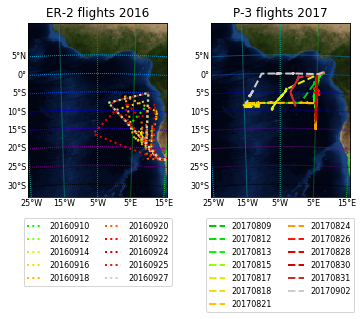

In [198]:
# plot flight path for paper
#ORACLES 2016 and 2017 2 subplots:
#plotORACLESflightPaths(flightpath_data,lat_s,lat_n,lat_0,lon_0,m_width,m_height)
#plotORACLESflightPaths(flightpath_data,-30.,10.,-10.,5.,6000000,5000000)
plotORACLESflightPaths_2subplots(flightpath_data,-30.,10.,-10.,-5.,4000000,5000000)

#plotRSPlatlon_winput(data_dir,"20160927","ER-2",-30.,5.,15.,5.,3000000,5000000)

#ORACLES 2017
#data_dir = '..//..//py_data//oracles_NN//input2NN//predictions//lut0//'
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170801","P-3",10.,30.,15.,-70.,4000000,3000000)
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170807","P-3",-20.,15,0,-40.,5000000,3500000)# transit
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170809","P-3",-20.,5.,-10,-5.,3000000,3500000)# including ASI
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170812","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170813","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170815","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170817","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170818","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170819","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170821","P-3",-20.,5.,-10,-5.,3000000,3500000)# including ASI
#plotRSPlatlon_winput(data_dir,"ref_i_ref_q","20170824","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170826","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_q_dolp","20170828","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS
#plotRSPlatlon_winput(data_dir,"ref_i_ref_q","20170830","P-3",-20.,5.,-10,5.,2500000,3500000)# Routine/TMS

In [237]:
## lat_1 - southern latitude
## lat_2 - northern latitude
## lat_0 - middle latitude
## lon_0 - middle longitude
## llcrnrlon=30.,llcrnrlat=20.,urcrnrlon=-160.,urcrnrlat=63
## m_width - width of draen map in projection units (e.g., 3500000)
## m_height- height of drawn map in projection units
## plot flight paths on map
## this plots both campaigns on one map
## this is for ORACLES 2016-17
##-----------------------------

def plotORACLESflightPaths_1subplot(data,lat_1,lat_2,lat_0,lon_0,m_width,m_height):
    
    # import moduls
    import numpy as np
    import scipy as sio
    from os import listdir
    from os.path import isfile, join
    from os import walk
    import pandas as pd
    import glob
    import matplotlib 
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    from matplotlib import cm
    from matplotlib import gridspec
    from matplotlib.collections import LineCollection
    from matplotlib.patches import Polygon
    from matplotlib.patches import Polygon
    from mpl_toolkits.basemap import Basemap
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import shapefile
    %matplotlib inline
    

    
    fig, axes = plt.subplots(1,1)
  
    projection = 'lcc'
    
    resolution = 'i'
    # ORACLES 2016
    #lat_1 = -30.
    #lat_2 = 5.
    #lat_0 = -15.
    #lon_0 = 5.
    m_min = lon_0 + (-20.)
    m_max = lon_0 + 25.

    parallels = np.arange(lat_1, lat_2, 5)
    meridians = np.arange(m_min, m_max, 10)
    
    # 2016-2017 flights
    #axes.set_title('ORACLES 2016-17 flights')
    m0 = Basemap(width = m_width, height = m_height,
                projection = projection,
                lat_1 = lat_1, lat_2 = lat_2, 
                lat_0 = lat_0, lon_0 = lon_0,
                resolution = resolution,ax=axes)
    
   
    m0.bluemarble(scale=0.25)
    m0.drawparallels(parallels, labels=[1,0,0,0], fontsize=8, 
       linewidth=1.)
    m0.drawmeridians(meridians, labels=[0,0,0,1], fontsize=8, 
       linewidth=1.)
   

    
    
    # set colormap
    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired
    
    # plot ER-2 paths
    subset = data[data['Platform']=="ER-2"]
    u_date = np.unique(subset['Date'])
    print u_date
    # ER-2
    for i in range(len(u_date)):
        print u_date[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0,label=Jday[i]
        #ax1.plot(radius,subdata.iloc[i,:].values,'-',linewidth=2.0)
        tmp = subset[subset['Date']==u_date[i]]
        #print tmp.head()
        
        m0.plot(np.asarray(tmp["Longitude"]),np.asarray(tmp["Latitude"]),':',
                latlon=True, linewidth=2.0,label=u_date[i])# works with axes[0].legend
        
    #P-3
    subset = data[data['Platform']=="P-3"]
    u_date = np.unique(subset['Date'])
    
    for i in range(len(u_date)):
        print u_date[i]
        
        tmp = subset[subset['Date']==u_date[i]]
        
        
        m0.plot(np.asarray(tmp["Longitude"]),np.asarray(tmp["Latitude"]),'--',
                latlon=True, linewidth=2.0,label=u_date[i])

    colors = [colormap(i) for i in np.linspace(0, 1,len(axes.lines))]
    
    for i,j in enumerate(axes.lines):
        j.set_color(colors[i])
    
    # Shrink current axis's height by 10% on the bottom
    box0 = axes.get_position()
    axes.set_position([box0.x0, box0.y0 + box0.height * 0.2,
                 box0.width, box0.height * 0.8])

    # Put a legend below current axis
    #axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #      fancybox=True, shadow=True, ncol=5)
    axes.legend(loc='upper center',bbox_to_anchor = (0.5, -0.1),
          fancybox=True, shadow=False, ncol=3,fontsize = 8)   
    
    # add location points:
    lons = [14.525, 6.6131, -14.356]
    lats = [-22.93, 0.1864, -7.947]
    x,y = m0(lons, lats)
    #m0.plot(lons, lats, 'go', markersize=14,latlon=True)
    m0.plot(x, y, 'go', markersize=8)
    labels = ['Walvis Bay', 'Sao Tome', 'Ascension Island']
    x_offsets = [-1500000, -500000, -800000]
    y_offsets = [-250000, 150000, -350000]
    
    for label, xpt, ypt, x_offset, y_offset in zip(labels, x, y, x_offsets, y_offsets):
        plt.text(xpt+x_offset, ypt+y_offset, label, color="white", fontsize = 8)
    
    #for label, xpt, ypt in zip(labels, x, y):
    #    plt.text(xpt, ypt, label)
    
    plt.show()

    #fig.savefig(filepath + title + '.png')
    
    # save figure
    # as pdf
    fi1 = '../../py_figs/oracles_NN/' + 'ORACLES2016_2017FlightPaths_1plot' + '.pdf'
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(13, 9, forward=True)
    fig.savefig(fi1, bbox_inches='tight',dpi=1000)
    # as png
    fi2 = '../../py_figs/oracles_NN/' + 'ORACLES2016_2017FlightPaths_1plot' + '.png'
    #fig = matplotlib.pyplot.gcf()
    #fig.set_size_inches(13, 9, forward=True)
    fig.savefig(fi2, bbox_inches='tight',dpi=1000)
    # or set axes interactively
    #for ax in fig.axes:
    #    ax.set_xlim(10, 20)
        
    
    
    
    return 
    

['20160910' '20160912' '20160914' '20160916' '20160918' '20160920'
 '20160922' '20160924' '20160925' '20160927']
20160910
20160912
20160914
20160916
20160918
20160920
20160922
20160924
20160925
20160927
20170809
20170812
20170813
20170815
20170817
20170818
20170821
20170824
20170826
20170828
20170830
20170831
20170902


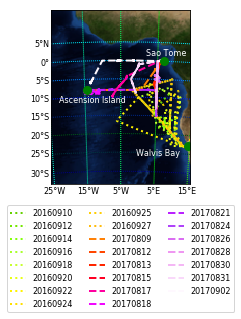

In [238]:
plotORACLESflightPaths_1subplot(flightpath_data,-30.,10.,-10.,-5.,4000000,5000000)